# **Introduction**

Welcome to the world of Molecular Dynamics! This lesson is to teach you the basic protocol of running a molecular dynamics (MD) simulation, including a bit of Python coding. If you don't know how to code, don't worry! These lessons assume no prior knowledge of code or Python.


A few things to start:

1.   These lessons only work in Google Chrome
2.   If you want to save your progress, go to File> Save a Copy in Drive; then locate a spot in your Drive folder
3.   Clicking the "play" button to the top left of a code block runs the code. Sometimes you can see the code and interact with it. However, if the code is hidden  it is to run adminstrative tasks in the background and you do not need to worry unless you are interested.
4. Sometimes the code may be hidden from view. To view it, click the '>' on the left of the title, until it changes to 'v'. This will reveal the code in that line.

Here are the files you will need for this code to run:
*   **.dcd** is a file format that store simulation trajectories. Simulation trajectories are a dynamic view of various properties in your protein, including atom coordinates, box size, velocities, and forces. Trajectory files looks at these variables as they change throughout time. You should have this file from your MD run.
*  A PDB ID or a .pdb file containing a set of atomic coordinates of your molecule. **.pdb** stands for a Protein Data Bank file. It is a file containing the three-dimensional structural data of your protein directly from the Protein Data Bank. If you run into errors with your PDB file, ask your instructor.



If you would like a tutorial on Python basics, please reference [this colab](https://colab.research.google.com/drive/1VaInetSJPAymyW51BRegmV4RLZXKdNLm?usp=sharing). It is not necessary to do this, however if you are interested in learning more about coding it is a great resource to use!

---


In [ ]:
#@title **Loading your packages (press PLAY)**
#@markdown Run this cell to install and load the R packages you will need for the analysis.
#@markdown To run a cell, place your cursor over the [ ] on the left, and press the play button (the brackets should turn into a play button).
#@markdown These packages will load some settings that are needed to run the rest of the code. You don't need to do anything except hit PLAY! Wait for the code to finish running before going to the next step.
#load packages

library(tidyverse, quietly = TRUE)
install.packages("bio3d", quiet = TRUE)
#install.packages("igraph", quiet = TRUE)
library(bio3d, quietly = TRUE)
#library(igraph, quietly = TRUE)

# Getting started - loading your files

In order to analyze your protein structures, you will need to upload the files containing what your protein looks like to your colab.

Here are the two types of files you should have. If you don't have these files, make sure that you ran the MD analysis colab before this one!



*   **.dcd** is a file format that store simulation trajectories. Simulation
trajectories are a dynamic view of various properties in your protein, including atom coordinates, box size, velocities, and forces. Trajectory files looks at these variables as they change throughout time.
*   **.pdb** stands for a Protein Data Bank file. It is a file containing the three-dimensional structural data of your protein directly from the Protein Data Bank.

---

Here are the setps to get the program will recognize your .dcd and .pdb files:

1. On the far left, click on the file folder. Right click inside the folder and create a folder called "inputs".
2. Create a second fold called "outputs".
3. Upload your .dcd file (with no solvent) and your first frame .pdb file into the inputs folder. Wait until the data is fully uploaded before proceeding. You will be able to see if it is uploaded by looking at the loading circle on the bottom left corner of your screen.
4. In the box containing the code, replace the x's in xxxx.dcd in the code with your filename (including the .dcd).
5. In the box containing the code, replace the x's in xxxx.pdb in the code with your filename (including the .pdb).
6. Run the code. The code will load your .pdb and .dcd files.

In [ ]:
# read the dcd file
dcd <- read.dcd("inputs/traj.dcd")
## load the pdb file
pdb <- read.pdb("inputs/model.pdb")

 NATOM = 10328 
 NFRAME= 250 
 ISTART= 0 
 last  = 250 
 nstep = 0 
 nfile = 0 
 NSAVE = 1 
 NDEGF = 0 
 version 24 
  |======================================================================| 100%


# Selecting atoms to analyze

This code will select the appropriate atoms in your molecule. Many times, we analyze proteins or biomolecules and only include the atoms in the "backbone" to reduce noise from mobile side chains (also known as R groups). For proteins these are the alpha carbons (CA or Calpha). This is the default in the code below, but if you are interested in a single piece/section of the protein such as an active site loop, you should select those atoms as indicated in the code after the ###. To use that code, put a # before the second line, delete the ### and select the atoms you would like to analyze (elety is the type of amino acids, and resno is the range of amino acids).

If no edits are necessary, press PLAY.

In [ ]:
# select the Calpha carbons for analysis
ca.inds <- atom.select(pdb, elety="CA") #put a # in front of this line if you use the one below
### ca.inds <- atom.select(pdb, elety = "CA", resno = 85:100) # selects Calphas of amino acids 85 to 100

# Aligning the trajectory

Now that the atom selections are set, we will now analyze the data on that selection. In most cases, the code runs without needing further user input and when it is needed, there will be indications.

Press PLAY.

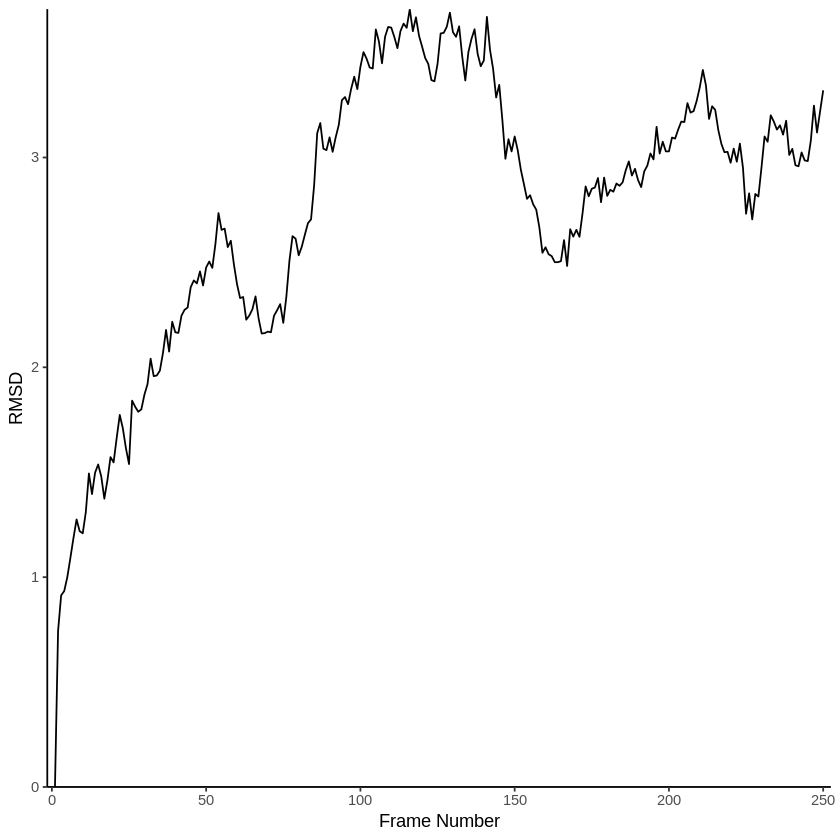

In [ ]:
# align all the frames on the initial pdb final
# align all the frames on the pdb file
xyz <- fit.xyz(fixed=pdb$xyz, mobile=dcd,
               fixed.inds=ca.inds$xyz,
               mobile.inds=ca.inds$xyz)

# calculate the RMSD for each frame and plot the data
rd <- rmsd(xyz[1,ca.inds$xyz], xyz[,ca.inds$xyz])
fr <- length(rd)
rd.plot <- tibble(frame = seq(from = 1, to = fr, by = 1),
                  rmsd = rd)

ggplot(rd.plot) +
  geom_line(aes(x = frame, y = rd)) +
  theme_classic() +
  scale_x_continuous(expand = c(0.01,0)) +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = "Frame Number", y = "RMSD")

write_csv(rd.plot, "outputs/rmsd_data.csv")

# Analyzing the dynamics

In the next several blocks, we will look at the dynamics on residue and whole protein level. No edits should be necessary.

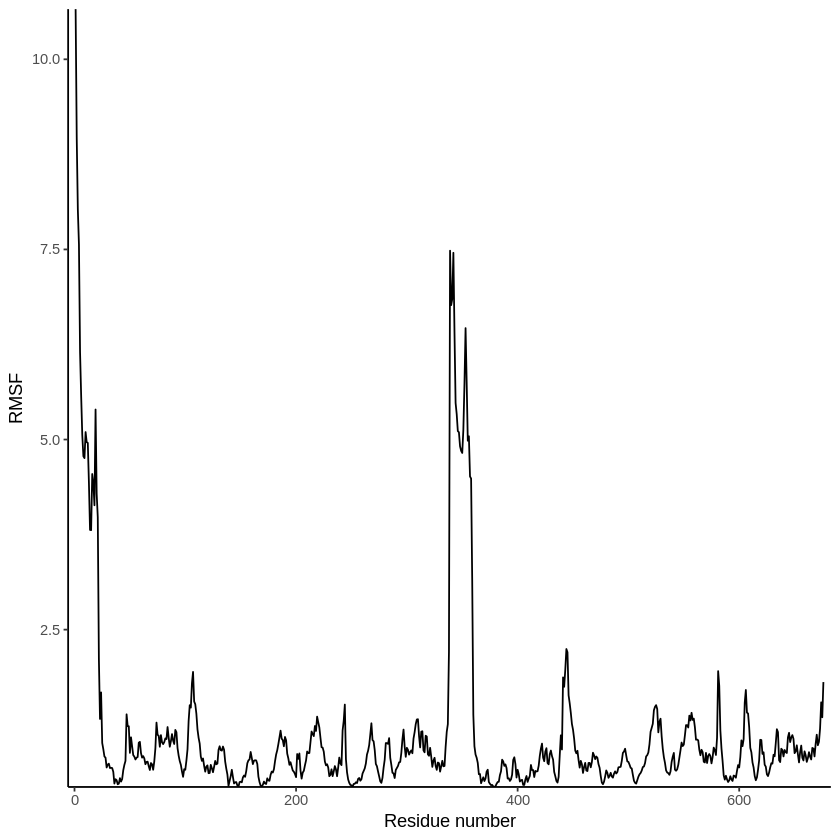

In [ ]:
# calculate the root mean square flucuation
rf <- rmsf(xyz[,ca.inds$xyz])
aas <- length(rf)
rf.plot <- tibble(aa_num = seq(from = 1, to = aas, by = 1),
                  rmsf = rf)

ggplot(rf.plot) +
  geom_line(aes(x = aa_num, y = rf)) +
  theme_classic() +
  scale_x_continuous(expand = c(0.01,0)) +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = "Residue number", y = "RMSF")

write_csv(rf.plot, "outputs/rmsf_data.csv")

## Principle component analysis (pca)
In this section, the dynamics will be broken down into specific motions or components that occur during the simulation. This can often reveal conformational changes that are occuring.
These motions can then be further be broken down to the amino acid level to indicate where specific dynamics are occuring over the entire simulation. For example, if there is a specific amino acid that is causing a change in protein structure, this component analysis will let us know. Edits may be needed, so pay attention to the comments in the hashtags!

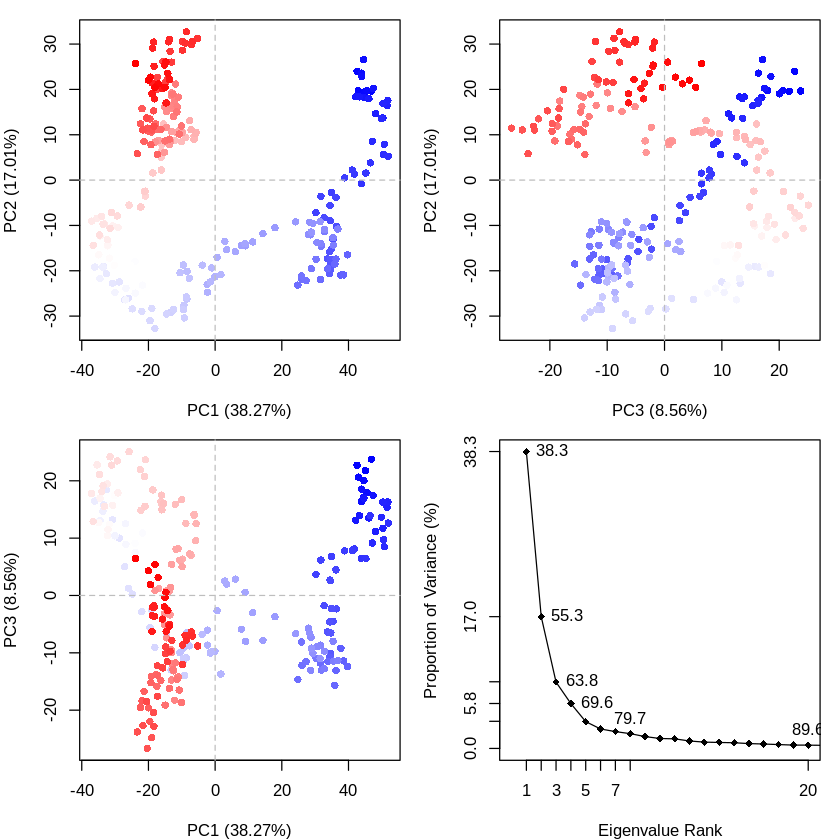

In [ ]:
# principle component analysis
pc <- pca.xyz(xyz[,ca.inds$xyz])

# plot a quick summary
pc <- pca.xyz(xyz[,ca.inds$xyz])
plot(pc, col=bwr.colors(nrow(xyz)) )

# make the pca data
# if the eigenrank plot (bottom right) indicates that more than 5 PCs are important,
##just add "pc(number) = pc$z[,(column number)]" to the frame below, and make sure to add commas and parentheses where needed.
pca_df <- tibble(frame = seq(from = 1, to = fr, by = 1),
                 pc1 = pc$z[,1],
                 pc2 = pc$z[,2],
                 pc3 = pc$z[,3],
                 pc4 = pc$z[,4],
                 pc5 = pc$z[,5])

write_csv(pca_df, "outputs/pca_data.csv")

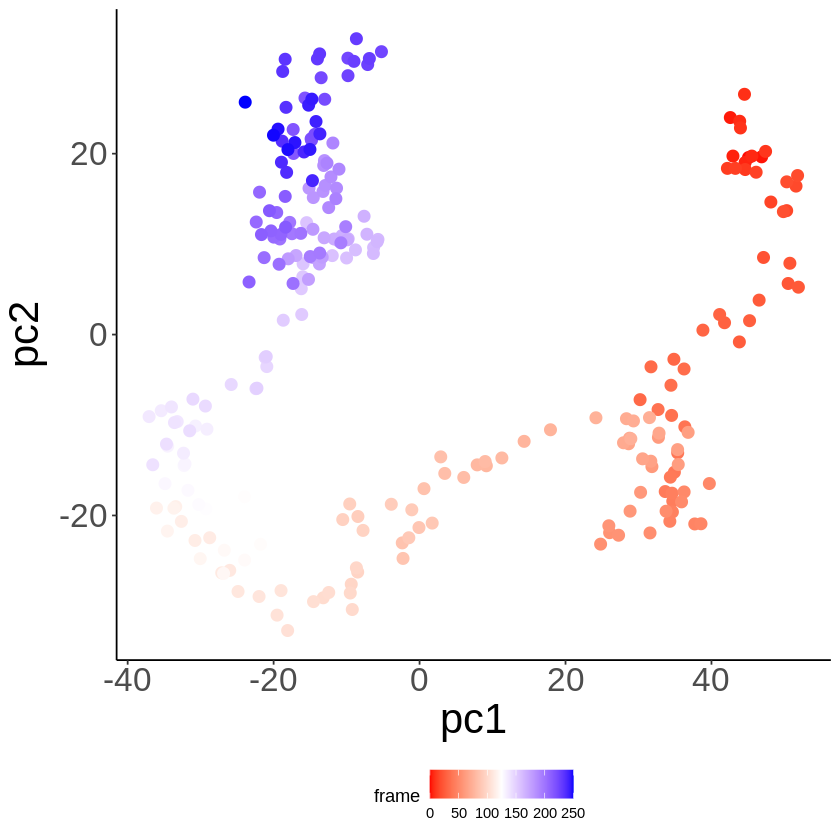

In [ ]:
# plot pca at higher resolution in ggplot
# can change principle component comparisons by changing the number after pc in the geom_point in line 7 (example: x = pc1 --> x = pc2)
# points colored red -> blue, frame 1 -> last frame
m = fr/2

ggplot(pca_df) +
  geom_point(aes(x = pc1, y = pc2, color = frame), size = 3) +
  scale_color_gradient2(low = "red", mid = "white", high = "blue", limits = c(0, fr), midpoint = m) +
  theme_classic() +
  theme(axis.title = element_text(size = 25),
        axis.text = element_text(size = 20),
        legend.position = "bottom")


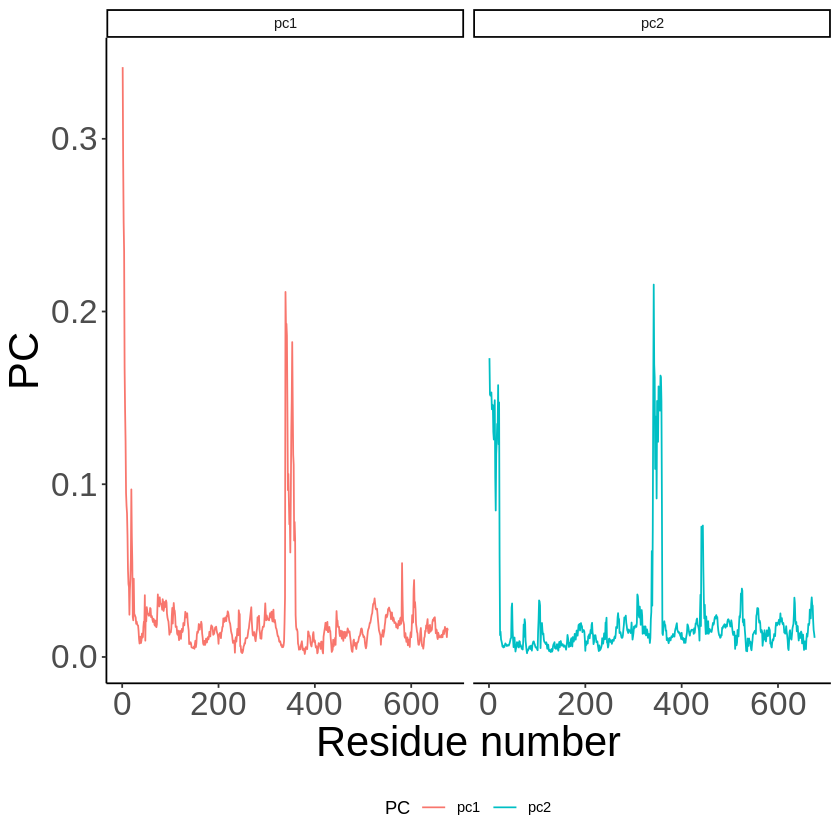

In [ ]:
# Residue level PCA
# make the pca data
pca_res_df <- tibble(residue = seq(from = 1, to = aas, by = 1),
                 pc1 = pc$au[,1],
                 pc2 = pc$au[,2],
                 pc3 = pc$au[,3],
                 pc4 = pc$au[,4],
                 pc5 = pc$au[,5])

write_csv(pca_res_df, "outputs/pca__residue_data.csv")

# make the data long
pca_res_df_long <- pca_res_df %>%
  pivot_longer(2:3, names_to = "PC", values_to = "value")

ggplot(pca_res_df_long) +
  geom_line(aes(x = residue, y = value, color = PC)) +
  theme_classic() +
  theme(axis.title = element_text(size = 25),
        axis.text = element_text(size = 20),
        legend.position = "bottom") +
  labs(x = "Residue number", y = "PC") +
  facet_grid(.~PC)

# Correlation calculations
So far the calculations have focused on where and when motion is occuring. The next set of analyses take a look at the correlation in the motion between individual amino acids and communities of amino acids.
The dynamic cross correlation presents a heat map of which amino acids are correlated or anti-correlated in motion.
The network analysis aims to identify common groups in the protein that move together, which is sometimes indicative of functional domains and allostery.

No edits should be necessary. Press PLAY. Ignore the warning message.


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


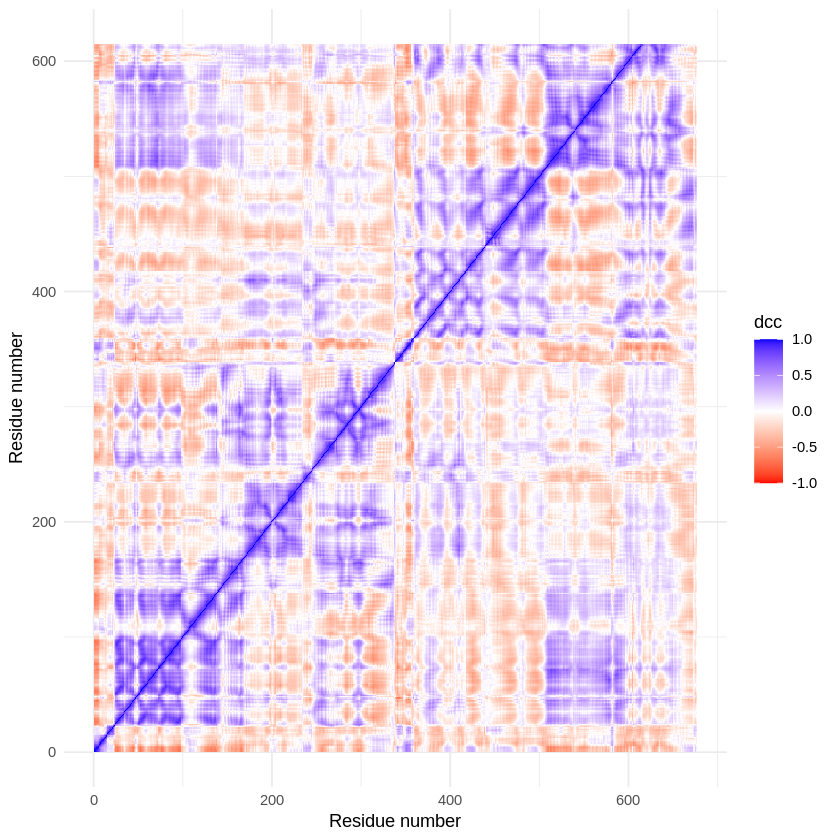

In [ ]:
# dynamic cross correlation matrix
cij<-dccm(xyz[,ca.inds$xyz])

# convert to a csv file
cij_df <- as_tibble(cij)
res <- length(cij_df)
colnames(cij_df) <- seq(from = 1, to = res, by = 1)
cij_df$res <- seq(from = 1, to = res, by = 1)

write_csv(cij_df, "outputs/dccm_data.csv")

cij_long <- cij_df %>%
  pivot_longer(1:614, names_to = "resy", values_to = "dcc") %>%
  mutate(resy = as.numeric(resy),
         dcc = as.numeric(dcc))

ggplot(cij_long) +
  geom_tile(aes(x = res, y = resy, fill = dcc)) +
  scale_fill_gradient2(low = "red", mid = "white", high = "blue", limits = c(-1,1)) +
  theme_minimal() +
  labs(x = "Residue number", y = "Residue number")


# **DOWNLOAD YOUR DATA FROM THE OUTPUTS FOLDER!! :-)**

